In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import os
path = "src/data/outputs"
plots_path = "src/data/outputs/plots/game_theory/stability_PD/"
keep_games = ["prisoners"]

In [3]:
dfs = []
game_names = []
game_id = []
for file in os.listdir(path):
    if file.endswith("_solved.csv"):
        dfs.append(pd.read_csv(os.path.join(path, file),  converters={
    'agent_1_scores': lambda x: list(map(int, x.strip('[]').split(','))),
    'agent_2_scores': lambda x: list(map(int, x.strip('[]').split(','))),
    'total_rounds': int
}))
        game_names.append(file.split("_")[0])
        game_id.append(file.split("_solved.csv")[0].split("_")[-1])
        for i, df in enumerate(dfs):
            df['GameName'] = game_names[i]
            df['GameID'] = game_id[i]
df = pd.concat(dfs, ignore_index=True)
df = df.loc[:, ~df.columns.str.startswith('Unnamed')]
df = df[df['GameName'].isin(keep_games)]


df['agent_1_cumulative_scores'] = df['agent_1_scores'].apply(lambda x: [0] + list(pd.Series(x).cumsum()))
df['agent_2_cumulative_scores'] = df['agent_2_scores'].apply(lambda x: [0] + list(pd.Series(x).cumsum()))

#parse as lists, something went wrong when saving the csv
df['truthful_agent_1'] = df['truthful_agent_1'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df['truthful_agent_2'] = df['truthful_agent_2'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
# Parse the actions as lists of strings
df['agent_1_actions'] = df['agent_1_actions'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df['agent_2_actions'] = df['agent_2_actions'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df['agent_1_messages'] = df['agent_1_messages'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df['agent_2_messages'] = df['agent_2_messages'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df['intent_agent_1'] = df['intent_agent_1'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df['intent_agent_2'] = df['intent_agent_2'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Create a new DataFrame with one row per agent
df_agent1 = df.copy()
df_agent2 = df.copy()

# Add a column to indicate the agent
df_agent1['Agent'] = 'Agent 1'
df_agent2['Agent'] = 'Agent 2'
# Rename columns to remove agent-specific prefixes
df_agent1 = df_agent1.rename(columns={
    'personality_1': 'Personality',
    'agent_1_scores': 'Scores',
    'agent_1_messages': 'Messages',
    'agent_1_actions': 'Actions',
    'agent_1_cumulative_scores': 'CumulativeScores',
    'intent_agent_1': 'Intent',
    'truthful_agent_1': 'Truthful',
    'analysis_agent_1': 'Analysis'
})

df_agent2 = df_agent2.rename(columns={
    'personality_2': 'Personality',
    'agent_2_scores': 'Scores',
    'agent_2_messages': 'Messages',
    'agent_2_actions': 'Actions',
    'agent_2_cumulative_scores': 'CumulativeScores',
    'intent_agent_2': 'Intent',
    'truthful_agent_2': 'Truthful',
    'analysis_agent_2': 'Analysis'
})

# Remove the other columns
df_agent1 = df_agent1.drop(columns=[
    'personality_2', 'agent_2_scores', 'agent_2_messages', 'agent_2_actions', 
    'agent_2_cumulative_scores', 'intent_agent_2', 'truthful_agent_2', 'analysis_agent_2'
])
df_agent2 = df_agent2.drop(columns=[
    'personality_1', 'agent_1_scores', 'agent_1_messages', 'agent_1_actions', 
    'agent_1_cumulative_scores', 'intent_agent_1', 'truthful_agent_1', 'analysis_agent_1'
])

# Combine the two DataFrames
df_agents = pd.concat([df_agent1, df_agent2], ignore_index=True)

nonmbti = ['NONE', 'ALTRUISTIC', 'SELFISH']
# Map each personality to its dichotomies
df_agents['I/E'] = df_agents['Personality'].apply(lambda x: 'I' if x[0] == 'I' else 'E' if x not in nonmbti else None)
df_agents['N/S'] = df_agents['Personality'].apply(lambda x: 'N' if x[1] == 'N' else 'S' if x not in nonmbti else None)
df_agents['T/F'] = df_agents['Personality'].apply(lambda x: 'T' if x[2] == 'T' else 'F' if x not in nonmbti else None)
df_agents['J/P'] = df_agents['Personality'].apply(lambda x: 'J' if x[3] == 'J' else 'P' if x not in nonmbti else None)

#df_agents.to_csv("/cluster/home/mlindner/Github/master_thesis_project/src/data/outputs/plots/stability_PD/stability_PD.csv", index=False)

In [4]:
df_agents["TotalScore"] = df_agents["CumulativeScores"].apply(lambda x: x[-1])
df_agents["Truthfullness"] = df_agents["Truthful"].apply(lambda x: sum(x)/len(x) if len(x) > 0 else 0)

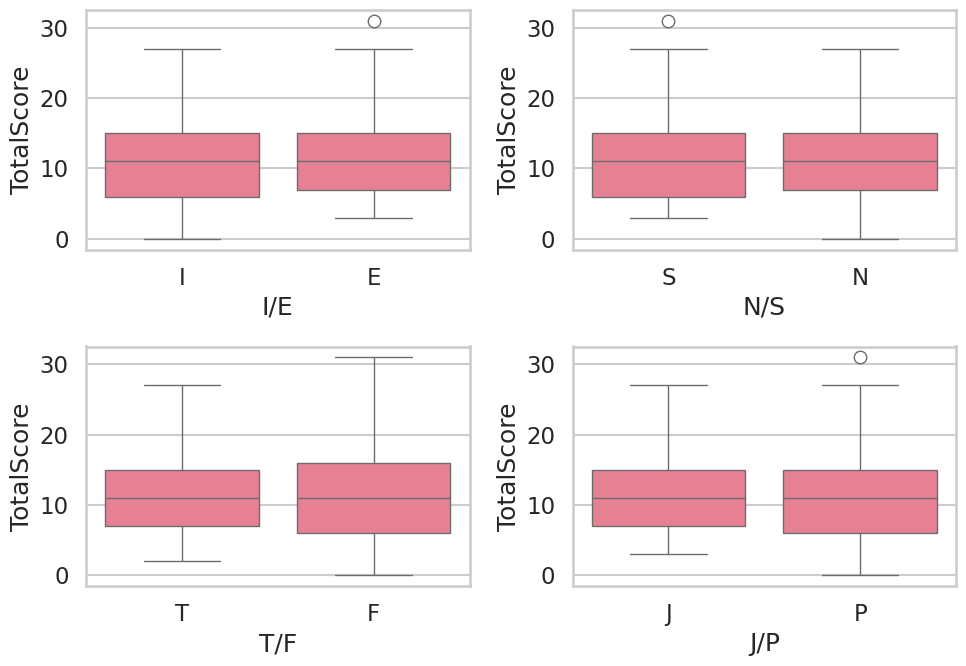

In [9]:
#plot score on y-axis and row on x-axis for individual dichotomies
sns.set(style="whitegrid")
sns.set_context("talk")
sns.set_palette("husl")
fig, axs = plt.subplots(2, 2, figsize=(10, 7))
sns.boxplot(x='I/E', y='TotalScore', data=df_agents, ax=axs[0, 0])
sns.boxplot(x='N/S', y='TotalScore', data=df_agents, ax=axs[0, 1])
sns.boxplot(x='T/F', y='TotalScore', data=df_agents, ax=axs[1, 0])
sns.boxplot(x='J/P', y='TotalScore', data=df_agents, ax=axs[1, 1])
plt.tight_layout()
plt.savefig(plots_path + "score_per_dichotomy.png")
plt.show()

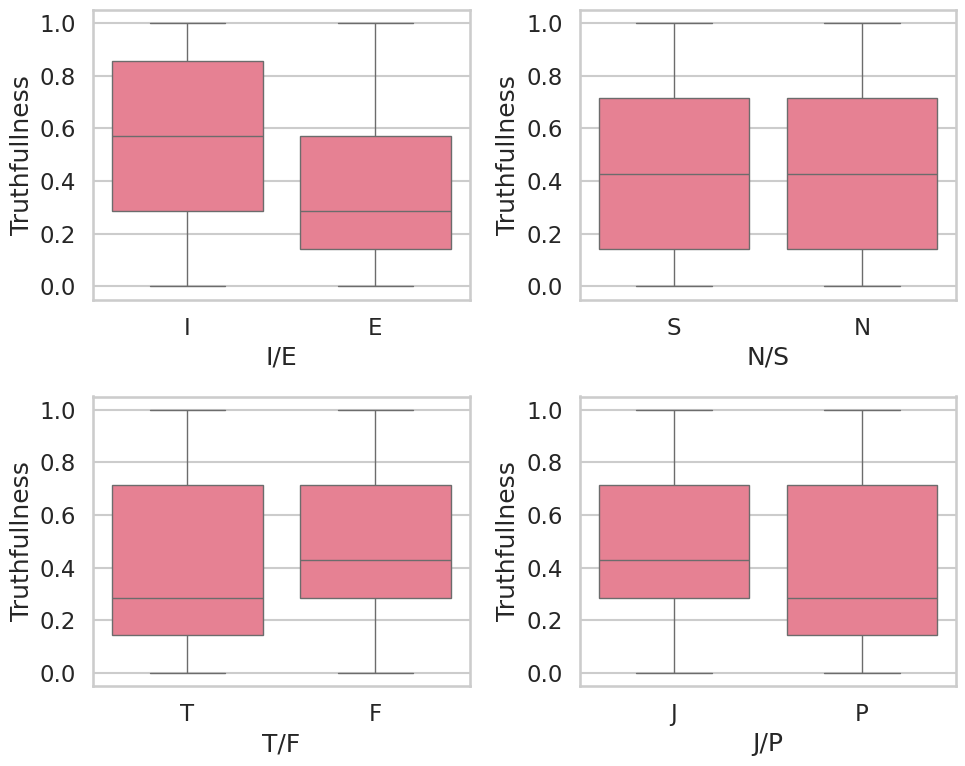

In [10]:
#plot score on y-axis and row on x-axis for individual dichotomies
sns.set(style="whitegrid")
sns.set_context("talk")
sns.set_palette("husl")
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
sns.boxplot(x='I/E', y='Truthfullness', data=df_agents, ax=axs[0, 0])
sns.boxplot(x='N/S', y='Truthfullness', data=df_agents, ax=axs[0, 1])
sns.boxplot(x='T/F', y='Truthfullness', data=df_agents, ax=axs[1, 0])
sns.boxplot(x='J/P', y='Truthfullness', data=df_agents, ax=axs[1, 1])
plt.tight_layout()
plt.savefig(plots_path + "truthfullness_per_dichotomy.png")
plt.show()

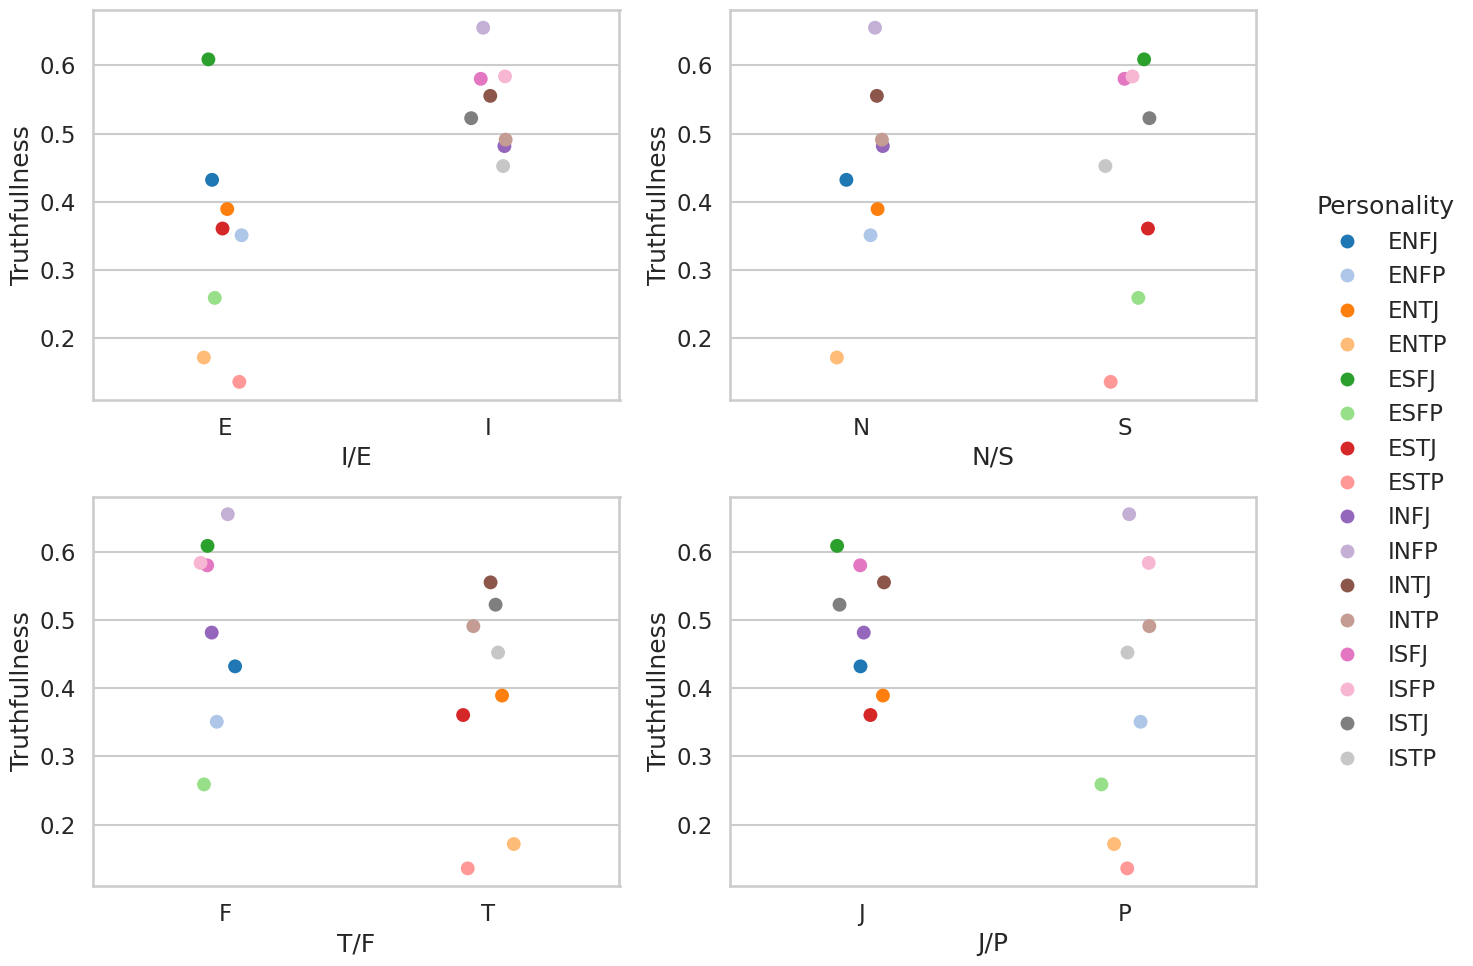

In [29]:
# Create a full Personality column
df_agents['Personality'] = df_agents['I/E'] + df_agents['N/S'] + df_agents['T/F'] + df_agents['J/P']

# Re-group, keeping personality
df_grouped_game = df_agents.groupby(['GameName', 'Personality', 'I/E', 'N/S', 'T/F', 'J/P'])['Truthfullness'].mean().reset_index()

# Define consistent Set2 palette (supports up to 8 colors, so we’ll loop if needed)
base_palette = sns.color_palette("tab20")
num_personalities = df_grouped_game['Personality'].nunique()
palette = dict(zip(
    sorted(df_grouped_game['Personality'].unique()),
    (base_palette * (num_personalities // len(base_palette) + 1))[:num_personalities]
))

# Plot
sns.set(style="whitegrid")
sns.set_context("talk")

fig, axs = plt.subplots(2, 2, figsize=(13, 10))

# Strip plots by dichotomy with color by full Personality & larger dots
sns.stripplot(x='I/E', y='Truthfullness', hue='Personality', data=df_grouped_game,
              ax=axs[0, 0], palette=palette, jitter=True, dodge=False, size=10)

sns.stripplot(x='N/S', y='Truthfullness', hue='Personality', data=df_grouped_game,
              ax=axs[0, 1], palette=palette, jitter=True, dodge=False, size=10)

sns.stripplot(x='T/F', y='Truthfullness', hue='Personality', data=df_grouped_game,
              ax=axs[1, 0], palette=palette, jitter=True, dodge=False, size=10)

sns.stripplot(x='J/P', y='Truthfullness', hue='Personality', data=df_grouped_game,
              ax=axs[1, 1], palette=palette, jitter=True, dodge=False, size=10)

# Remove duplicate legends and place one outside the entire figure
for ax in axs.flat:
    ax.get_legend().remove()

# Create a single legend to the right of the figure
handles, labels = axs[1, 1].get_legend_handles_labels()
fig.legend(handles, labels, title='Personality', loc='center left', bbox_to_anchor=(1.01, 0.5), frameon=False)

plt.tight_layout(rect=[0, 0, 1, 1])  # Leave space on the right for legend
plt.savefig(plots_path + 'truthfullness_stripplot_dichotomies.png', dpi=300, bbox_inches='tight')
plt.show()
